In [10]:
import tensorflow as tf
from tqdm import tqdm

from Client import Clients
import os
import numpy as np
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
def buildClients(num, local_client_number=1):
    learning_rate = 0.0001
    num_input = 32  # image shape: 32*32
    num_input_channel = 3  # image channel: 3
    num_classes = 3  # Cifar-10 total classes (0-9 digits)

    #create Client and model
    return Clients(input_shape=[None, num_input, num_input, num_input_channel],
                  num_classes=num_classes,
                  learning_rate=learning_rate,
                  clients_num=num,
                   local_client_number=local_client_number
                   )


def run_global_test(client, global_vars, test_num):
    client.set_global_vars(global_vars)
    acc, loss = client.run_test(test_num)
    print("[epoch {}, {} inst] Testing ACC: {:.4f}, Loss: {:.4f}".format(
        ep + 1, test_num, acc, loss))
    return acc, loss


In [11]:

#### SOME TRAINING PARAMS ####
CLIENT_NUMBER = 2
LOCAL_CLIENT_NUMBER = 2
CLIENT_RATIO_PER_ROUND = 1
LOCAL_CLIENT_RATIO_PER_ROUND = 1
epoch = 100

In [12]:

#### CREATE CLIENT AND LOAD DATASET ####
client = buildClients(CLIENT_NUMBER, LOCAL_CLIENT_NUMBER)
import json
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)




['E:\\data\\aslam\\COVID19-XRay-Dataset-master\\COVID19-XRay-Dataset-master\\train\\covid\\03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg', 'E:\\data\\aslam\\COVID19-XRay-Dataset-master\\COVID19-XRay-Dataset-master\\train\\covid\\1-s2.0-S0140673620303706-fx1_lrg.jpg', 'E:\\data\\aslam\\COVID19-XRay-Dataset-master\\COVID19-XRay-Dataset-master\\train\\covid\\1-s2.0-S0929664620300449-gr2_lrg-a.jpg', 'E:\\data\\aslam\\COVID19-XRay-Dataset-master\\COVID19-XRay-Dataset-master\\train\\covid\\1-s2.0-S0929664620300449-gr2_lrg-c.jpg', 'E:\\data\\aslam\\COVID19-XRay-Dataset-master\\COVID19-XRay-Dataset-master\\train\\covid\\1-s2.0-S0929664620300449-gr2_lrg-d.jpg', 'E:\\data\\aslam\\COVID19-XRay-Dataset-master\\COVID19-XRay-Dataset-master\\train\\covid\\1-s2.0-S1684118220300608-main.pdf-002.jpg', 'E:\\data\\aslam\\COVID19-XRay-Dataset-master\\COVID19-XRay-Dataset-master\\train\\covid\\1-s2.0-S1684118220300682-main.pdf-002-a2.png', 'E:\\data\\aslam\\COVID19-XRay-Dataset-master\\COVID19-XRay-Dataset-mast

In [ ]:

#### BEGIN TRAINING ####
global_vars3 = client.get_client_vars()
for client_number in [5, 10, 15]:
    for lower_client_number in [2, 3, 4, 5]:
        print(client_number, lower_client_number)
        CLIENT_NUMBER = client_number
        LOCAL_CLIENT_NUMBER = lower_client_number
        key = str(client_number) + "_" + str(lower_client_number)
        global_vars = client.get_client_vars()
        client.set_global_vars(global_vars3)
        for ep in range(epoch):
            random_clients = client.choose_clients(CLIENT_RATIO_PER_ROUND)
            global_weights2 = client.get_client_vars()
            init_local_weights = [global_weights2 for _ in range(CLIENT_NUMBER)]
            for client_id in random_clients:
                local_random_clients = client.choose_local_clients(LOCAL_CLIENT_RATIO_PER_ROUND)
                local_client_vars_list = [[] for _ in range(LOCAL_CLIENT_NUMBER)]
                client_local_vars_sum = None
                for local_client_id in local_random_clients:
                    client.set_global_vars(init_local_weights[client_id])
                    client.train_epoch(cid=client_id, lcid=local_client_id)
                    current_client_vars = client.get_client_vars()
                    # sum it up
                    if client_local_vars_sum is None:
                        client_local_vars_sum = current_client_vars
                    else:
                        for cv, ccv in zip(client_local_vars_sum, current_client_vars):
                            cv += ccv
                # average_weights =  client_local_vars_sum / local_random_clients
                average_weights = []
                for var in client_local_vars_sum:
                    average_weights.append(var / len(local_random_clients))
                init_local_weights[client_id] = average_weights



            # We are going to sum up active clients' vars at each epoch
            client_vars_sum = None

            # Train with these clients
            for client_id in random_clients:
                # Restore global vars to client's model
                client.set_global_vars(init_local_weights[client_id])

                # train one client
                client.train_epoch(cid=client_id, lcid=0)

                # obtain current client's vars
                current_client_vars = client.get_client_vars()

                # sum it up
                if client_vars_sum is None:
                    client_vars_sum = current_client_vars
                else:
                    for cv, ccv in zip(client_vars_sum, current_client_vars):
                        cv += ccv

            # obtain the avg vars as global vars
            global_vars = []
            for var in client_vars_sum:
                global_vars.append(var / len(random_clients))

            # run test on 1000 instances
            acc, loss = run_global_test(client, global_vars, test_num=80)
            with open("acc_loss.txt", "r") as f:
                import json
                dic = json.load(f)

            with open("acc_loss.txt", "w") as f:
                import json
                small_dic = dic.get(key, {})
                small_dic[ep] = [acc, loss]
                dic[key] = small_dic
                json.dump(dic, f, cls=MyEncoder)


5 2
[epoch 1, 80 inst] Testing ACC: 0.3625, Loss: 1.1398
[epoch 2, 80 inst] Testing ACC: 0.3500, Loss: 1.1470
[epoch 3, 80 inst] Testing ACC: 0.3125, Loss: 1.1682
[epoch 4, 80 inst] Testing ACC: 0.3125, Loss: 1.1691
[epoch 5, 80 inst] Testing ACC: 0.3125, Loss: 1.1652
[epoch 6, 80 inst] Testing ACC: 0.3500, Loss: 1.1448
[epoch 7, 80 inst] Testing ACC: 0.3375, Loss: 1.1480
[epoch 8, 80 inst] Testing ACC: 0.3250, Loss: 1.1581
[epoch 9, 80 inst] Testing ACC: 0.3375, Loss: 1.1519
[epoch 10, 80 inst] Testing ACC: 0.3625, Loss: 1.1342
[epoch 11, 80 inst] Testing ACC: 0.3500, Loss: 1.1436
[epoch 12, 80 inst] Testing ACC: 0.3125, Loss: 1.1639
[epoch 13, 80 inst] Testing ACC: 0.3125, Loss: 1.1665
[epoch 14, 80 inst] Testing ACC: 0.3125, Loss: 1.1620
[epoch 15, 80 inst] Testing ACC: 0.3500, Loss: 1.1345
[epoch 16, 80 inst] Testing ACC: 0.3375, Loss: 1.1393
[epoch 17, 80 inst] Testing ACC: 0.3250, Loss: 1.1453
[epoch 18, 80 inst] Testing ACC: 0.3375, Loss: 1.1429
[epoch 19, 80 inst] Testing ACC: 

[epoch 53, 80 inst] Testing ACC: 0.3375, Loss: 1.1026
[epoch 54, 80 inst] Testing ACC: 0.3625, Loss: 1.0852
[epoch 55, 80 inst] Testing ACC: 0.3500, Loss: 1.0904
[epoch 56, 80 inst] Testing ACC: 0.3125, Loss: 1.0940
[epoch 57, 80 inst] Testing ACC: 0.3125, Loss: 1.0792
[epoch 58, 80 inst] Testing ACC: 0.3125, Loss: 1.1030
[epoch 59, 80 inst] Testing ACC: 0.3500, Loss: 1.0365
[epoch 60, 80 inst] Testing ACC: 0.3375, Loss: 1.0221
[epoch 61, 80 inst] Testing ACC: 0.3250, Loss: 1.0224
[epoch 62, 80 inst] Testing ACC: 0.3375, Loss: 1.0136
[epoch 63, 80 inst] Testing ACC: 0.3625, Loss: 0.9712
[epoch 64, 80 inst] Testing ACC: 0.5000, Loss: 0.9355
[epoch 65, 80 inst] Testing ACC: 0.4750, Loss: 0.9276
[epoch 66, 80 inst] Testing ACC: 0.3125, Loss: 1.1230
[epoch 67, 80 inst] Testing ACC: 0.6500, Loss: 0.8735
[epoch 68, 80 inst] Testing ACC: 0.6375, Loss: 0.8474
[epoch 69, 80 inst] Testing ACC: 0.3875, Loss: 0.9637
[epoch 70, 80 inst] Testing ACC: 0.6000, Loss: 0.7888
[epoch 71, 80 inst] Testing 

[epoch 5, 80 inst] Testing ACC: 0.3250, Loss: 1.1436
[epoch 6, 80 inst] Testing ACC: 0.3375, Loss: 1.1399
[epoch 7, 80 inst] Testing ACC: 0.3625, Loss: 1.1320
[epoch 8, 80 inst] Testing ACC: 0.3500, Loss: 1.1368
[epoch 9, 80 inst] Testing ACC: 0.3125, Loss: 1.1559
[epoch 10, 80 inst] Testing ACC: 0.3125, Loss: 1.1578
[epoch 11, 80 inst] Testing ACC: 0.3125, Loss: 1.1572
[epoch 12, 80 inst] Testing ACC: 0.3500, Loss: 1.1399
[epoch 13, 80 inst] Testing ACC: 0.3375, Loss: 1.1451
[epoch 14, 80 inst] Testing ACC: 0.3250, Loss: 1.1532
[epoch 15, 80 inst] Testing ACC: 0.3375, Loss: 1.1450
[epoch 16, 80 inst] Testing ACC: 0.3625, Loss: 1.1325
[epoch 17, 80 inst] Testing ACC: 0.3500, Loss: 1.1390
[epoch 18, 80 inst] Testing ACC: 0.3125, Loss: 1.1603
[epoch 19, 80 inst] Testing ACC: 0.3125, Loss: 1.1606
[epoch 20, 80 inst] Testing ACC: 0.3125, Loss: 1.1609
[epoch 21, 80 inst] Testing ACC: 0.3500, Loss: 1.1390
[epoch 22, 80 inst] Testing ACC: 0.3375, Loss: 1.1474
[epoch 23, 80 inst] Testing ACC: 

[epoch 57, 80 inst] Testing ACC: 0.3375, Loss: 1.1418
[epoch 58, 80 inst] Testing ACC: 0.3250, Loss: 1.1517
[epoch 59, 80 inst] Testing ACC: 0.3375, Loss: 1.1425
[epoch 60, 80 inst] Testing ACC: 0.3625, Loss: 1.1196
[epoch 61, 80 inst] Testing ACC: 0.3500, Loss: 1.1286
[epoch 62, 80 inst] Testing ACC: 0.3125, Loss: 1.1555
[epoch 63, 80 inst] Testing ACC: 0.3125, Loss: 1.1546
[epoch 64, 80 inst] Testing ACC: 0.3125, Loss: 1.1533
[epoch 65, 80 inst] Testing ACC: 0.3500, Loss: 1.1245
[epoch 66, 80 inst] Testing ACC: 0.3375, Loss: 1.1261
[epoch 67, 80 inst] Testing ACC: 0.3250, Loss: 1.1360
[epoch 68, 80 inst] Testing ACC: 0.3375, Loss: 1.1278
[epoch 69, 80 inst] Testing ACC: 0.3625, Loss: 1.1019
[epoch 70, 80 inst] Testing ACC: 0.3500, Loss: 1.1106
[epoch 71, 80 inst] Testing ACC: 0.3125, Loss: 1.1283
[epoch 72, 80 inst] Testing ACC: 0.3125, Loss: 1.1222
[epoch 73, 80 inst] Testing ACC: 0.3125, Loss: 1.1197
[epoch 74, 80 inst] Testing ACC: 0.3500, Loss: 1.0919
[epoch 75, 80 inst] Testing 

[epoch 9, 80 inst] Testing ACC: 0.3500, Loss: 1.1415
[epoch 10, 80 inst] Testing ACC: 0.3375, Loss: 1.1469
[epoch 11, 80 inst] Testing ACC: 0.3250, Loss: 1.1556
[epoch 12, 80 inst] Testing ACC: 0.3375, Loss: 1.1473
[epoch 13, 80 inst] Testing ACC: 0.3625, Loss: 1.1367
[epoch 14, 80 inst] Testing ACC: 0.3500, Loss: 1.1449
[epoch 15, 80 inst] Testing ACC: 0.3125, Loss: 1.1686
[epoch 16, 80 inst] Testing ACC: 0.3125, Loss: 1.1694
[epoch 17, 80 inst] Testing ACC: 0.3125, Loss: 1.1697
[epoch 18, 80 inst] Testing ACC: 0.3500, Loss: 1.1432
[epoch 19, 80 inst] Testing ACC: 0.3375, Loss: 1.1504
[epoch 20, 80 inst] Testing ACC: 0.3250, Loss: 1.1590
[epoch 21, 80 inst] Testing ACC: 0.3375, Loss: 1.1483
[epoch 22, 80 inst] Testing ACC: 0.3625, Loss: 1.1340
[epoch 23, 80 inst] Testing ACC: 0.3500, Loss: 1.1401
[epoch 24, 80 inst] Testing ACC: 0.3125, Loss: 1.1625
[epoch 25, 80 inst] Testing ACC: 0.3125, Loss: 1.1646
[epoch 26, 80 inst] Testing ACC: 0.3125, Loss: 1.1627
[epoch 27, 80 inst] Testing A

[epoch 61, 80 inst] Testing ACC: 0.3125, Loss: 1.1634
[epoch 62, 80 inst] Testing ACC: 0.3500, Loss: 1.1374
[epoch 63, 80 inst] Testing ACC: 0.3375, Loss: 1.1481
[epoch 64, 80 inst] Testing ACC: 0.3250, Loss: 1.1557
[epoch 65, 80 inst] Testing ACC: 0.3375, Loss: 1.1462
[epoch 66, 80 inst] Testing ACC: 0.3625, Loss: 1.1281
[epoch 67, 80 inst] Testing ACC: 0.3500, Loss: 1.1364
[epoch 68, 80 inst] Testing ACC: 0.3125, Loss: 1.1620
[epoch 69, 80 inst] Testing ACC: 0.3125, Loss: 1.1620
[epoch 70, 80 inst] Testing ACC: 0.3125, Loss: 1.1650
[epoch 71, 80 inst] Testing ACC: 0.3500, Loss: 1.1402
[epoch 72, 80 inst] Testing ACC: 0.3375, Loss: 1.1505
[epoch 73, 80 inst] Testing ACC: 0.3250, Loss: 1.1573
[epoch 74, 80 inst] Testing ACC: 0.3375, Loss: 1.1467
[epoch 75, 80 inst] Testing ACC: 0.3625, Loss: 1.1299
[epoch 76, 80 inst] Testing ACC: 0.3500, Loss: 1.1396
[epoch 77, 80 inst] Testing ACC: 0.3125, Loss: 1.1674
[epoch 78, 80 inst] Testing ACC: 0.3125, Loss: 1.1638
[epoch 79, 80 inst] Testing 

[epoch 13, 80 inst] Testing ACC: 0.3125, Loss: 1.1614
[epoch 14, 80 inst] Testing ACC: 0.3125, Loss: 1.1602


In [ ]:

#### FINAL TEST ####
run_global_test(client, global_vars, test_num=80)

In [4]:
import matplotlib.pyplot as plt


def plot_graph(loss, acc, round):
    # make a figure
    fig = plt.figure(figsize=(16,8))
    # subplot loss
    ax1 = fig.add_subplot(121)
    # ax1.plot(loss,label='global_loss')
    for acc_ in acc:
        ax1.plot(acc_[:-1],label="%s LC, %s ILC"%(tuple(acc_[-1].split("_"))))
    ax1.set_xlabel('Communication Rounds')
    ax1.set_ylabel('Test Accuracy')
    ax1.set_title('Acc ')
    ax1.legend()
    
    ax2 = fig.add_subplot(122)
    # subplot acc
    for loss_ in loss:
        ax2.plot(loss_[:-1],label="%s LC, %s ILC"%(tuple(loss_[-1].split("_"))))
    
    ax2.set_xlabel('Communication Rounds')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss')
    ax2.legend()
    plt.tight_layout()
    plt.savefig("round_info/aslam.eps",format="eps")



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


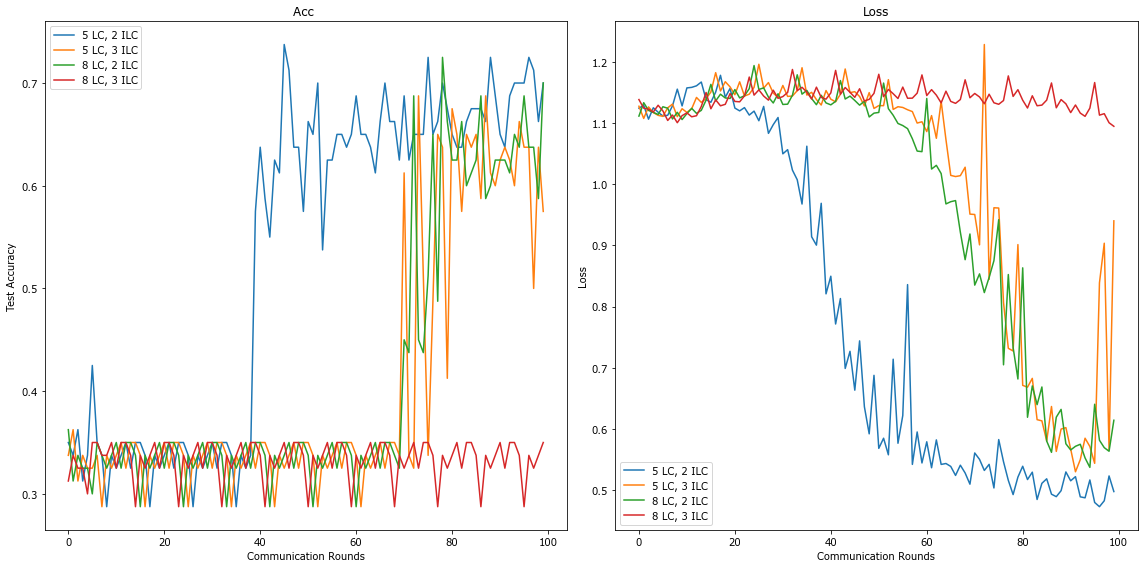

In [5]:
with open("acc_loss.txt", "r") as f:
    import json
    dic = json.load(f)
    lis = [i for i in dic.keys()]
    sorted(lis)
    loss = []
    acc = []
    for i in lis:
        lis2 = dic[i].keys()
        sorted(lis2)
        lis3 = [dic[i][j][1] for j in lis2]
        lis3.append(i)
        loss.append(lis3[:])
        
        lis4 = [dic[i][j][0] for j in lis2]
        lis4.append(i)
        acc.append(lis4[:])
    plot_graph(loss, acc, lis)